In [1]:
# Standard imports 
import numpy as np
from matplotlib import pyplot as plt
import colorcet as cc
import torchvision

# From the repository
from utils import load_image, make_grayscale, make_black_white, show_mask, show_mask_on_image, cut_image_with_mask
from vanilla_gradient import VanillaGradient
from guided_backprop import GuidedBackprop
from integrated_gradients import IntegratedGradients
from grad_cam import GradCam
from xrai import XRAI

In [4]:
# Load a pretrained model and image.
model = torchvision.models.resnet50(pretrained=True)
doberman = load_image('images/doberman.png', size=224)

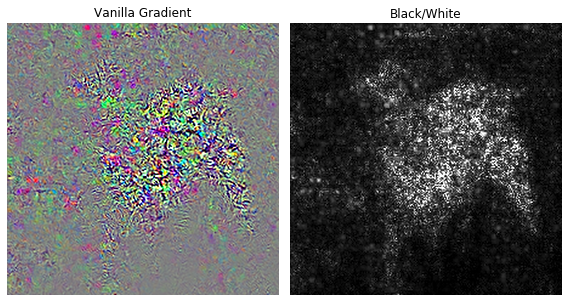

In [6]:
# Construct a saliency object and compute the saliency mask.
vanilla_gradient = VanillaGradient(model)
rgb_mask = vanilla_gradient.get_mask(image_tensor=doberman)

# Make a black and white variant of the computed saliency mask.
bw_mask = make_black_white(rgb_mask)

# Plot the RGB and black/white version alongside each other.
figure, axes = plt.subplots(1, 2, figsize=(8, 8), tight_layout=True)
show_mask(rgb_mask, title='Vanilla Gradient', axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])

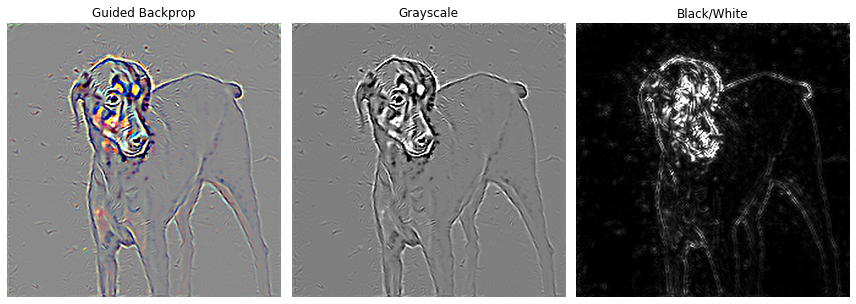

In [13]:
guided_backprop = GuidedBackprop(model)
rgb_mask = guided_backprop.get_mask(image_tensor=doberman)

# ReLUs are modified in PyTorch using hooks
# which we need to remove after we are done.
guided_backprop.remove_hooks()

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(rgb_mask, title='Guided Backprop', axis=axes[0])
show_mask(gray_mask, title='Grayscale', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[2])

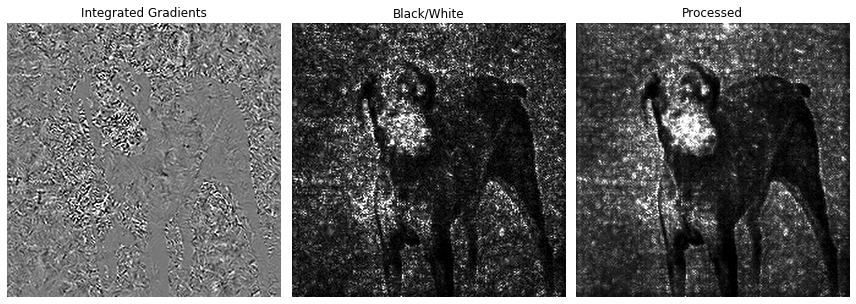

In [7]:
integrated_gradients = IntegratedGradients(model)
rgb_mask = integrated_gradients.get_mask(image_tensor=doberman)

# Individual gradients can be processed before being integrated
# by passing a function to the 'process' parameter of the
# 'get_mask' method. By passing e.g. 'np.abs' the visual result
# can be improved.
abs_rgb_mask = integrated_gradients.get_mask(image_tensor=doberman, process=np.abs)

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)
bw_mask_alt = make_black_white(abs_rgb_mask)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(gray_mask, title='Integrated Gradients', cmap=cc.cm.gray, axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask_alt, title='Processed', cmap=cc.cm.gray, axis=axes[2])

In [20]:
# Load another image and define a target class.
cat_dog = load_image('images/cat_dog.png', size=224)
class_boxer = 243  # Class 'bull mastiff
class_cat = 282  # Class 'tiger cat'

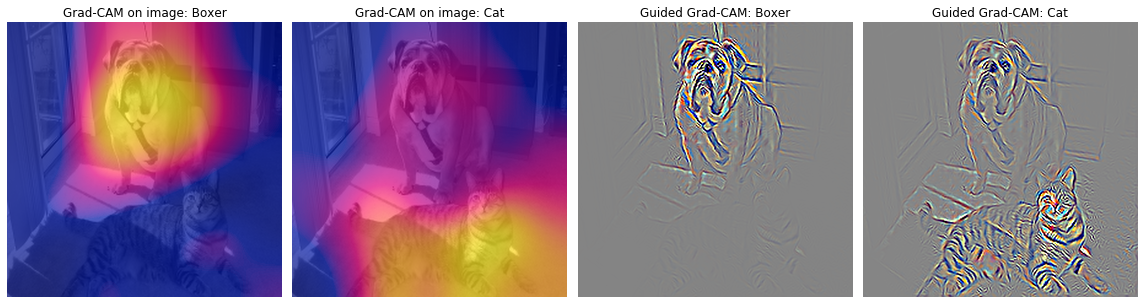

In [21]:
guided_backprop = GuidedBackprop(model)

# So far, the target class was set to the networks' prediction implicitly.
# Now, we define a desired target class explicitly.
boxer_mask = guided_backprop.get_mask(image_tensor=cat_dog, target_class=class_boxer)
cat_mask = guided_backprop.get_mask(image_tensor=cat_dog, target_class=class_cat)
guided_backprop.remove_hooks()

grad_cam = GradCam(model)
boxer_region = grad_cam.get_mask(image_tensor=cat_dog, target_class=class_boxer)
cat_region = grad_cam.get_mask(image_tensor=cat_dog, target_class=class_cat)
grad_cam.remove_hooks()

# 'Guided Grad-CAM' is a combination of the 'Guided Backprop' and 'Grad-CAM' method.
guided_grad_cam_boxer = guided_backprop.apply_region(boxer_mask, boxer_region)
guided_grad_cam_cat = guided_backprop.apply_region(cat_mask, cat_region)

figure, axes = plt.subplots(1, 4, figsize=(16, 16), tight_layout=True)
show_mask_on_image(image_path='images/cat_dog.png', mask=boxer_region, title='Grad-CAM on image: Boxer', axis=axes[0])
show_mask_on_image(image_path='images/cat_dog.png', mask=cat_region, title='Grad-CAM on image: Cat', axis=axes[1])
show_mask(guided_grad_cam_boxer, title='Guided Grad-CAM: Boxer', axis=axes[2])
show_mask(guided_grad_cam_cat, title='Guided Grad-CAM: Cat', axis=axes[3])

In [22]:
# Yet another model.
model = torchvision.models.inception_v3(pretrained=True)
doberman = load_image('images/doberman.png', size=299)

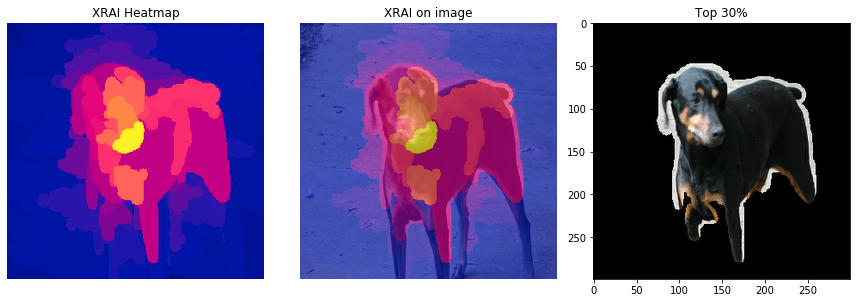

In [23]:
xrai = XRAI(model)
segments = xrai.get_mask(image_tensor=doberman)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=False, axis=axes[0])
show_mask_on_image(image_path='images/doberman.png', mask=segments, title='XRAI on image', axis=axes[1])
cut_image_with_mask(image_path='images/doberman.png', mask=segments, title='Top 30%', percentile=70, axis=axes[2])